# Python Image Processing Pipeline


Code was written with the assitance of ChatGPT to process a image file that consists of asteroids

Important to Install cv2 package

pip install opencv-python

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib  # needed to get the version

print("cv2 version:", cv2.__version__)
print("numpy version:", np.__version__)
print("matplotlib version:", matplotlib.__version__)

cv2 version: 4.11.0
numpy version: 1.23.5
matplotlib version: 3.7.0


# Preprocessing

In [2]:
# Load the image
img = cv2.imread("Asteroid_Image_Clean.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Show the orignal image

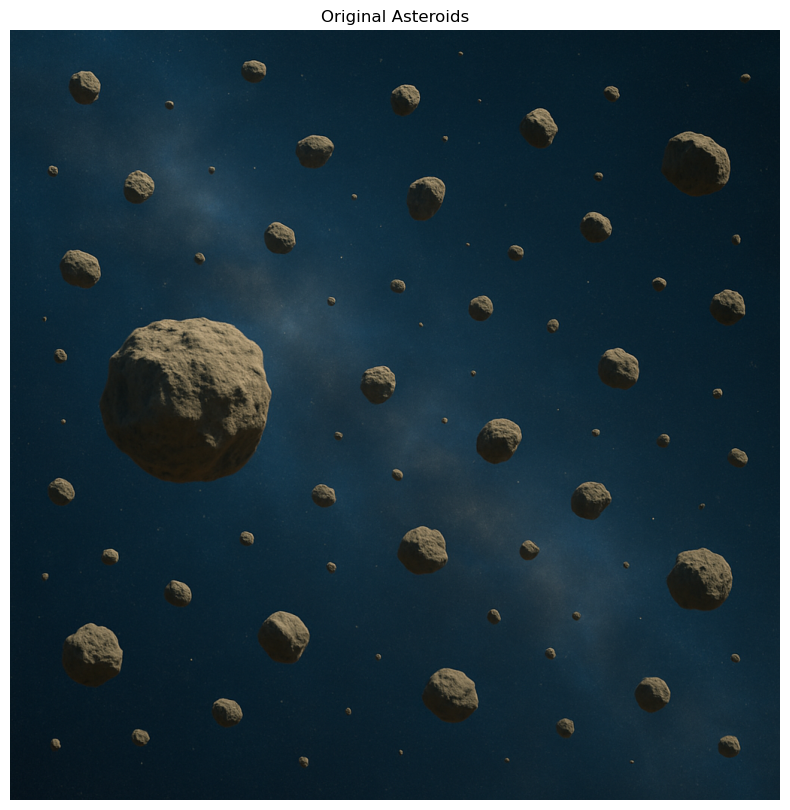

In [3]:
# If you already have 'img' as a BGR OpenCV image
# Convert BGR to RGB so matplotlib displays colors correctly
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display inline
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.title("Original Asteroids")
plt.axis('off')  # optional: hide axes
plt.show()

# 2. Edge or Threshold Detection

In [4]:
edges = cv2.Canny(blurred, threshold1=50, threshold2=150)
# OR try adaptive threshold:
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                               cv2.THRESH_BINARY_INV, 11, 3)

# 3. Find Contours

In [5]:
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Collect All Contour Areas

In [6]:
areas = [cv2.contourArea(cnt) for cnt in contours]

# Optimize the Min Area Cutoff to Reduce Noise

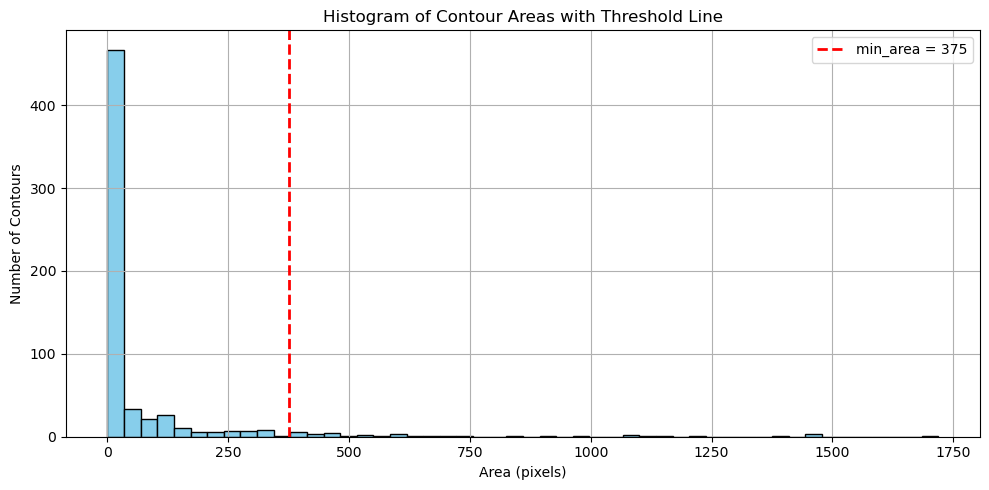

In [7]:
min_area_threshold = 375  # or any value you want to test determined from prior examination

plt.figure(figsize=(10, 5))
plt.hist(areas, bins=50, color='skyblue', edgecolor='black')
plt.axvline(min_area_threshold, color='red', linestyle='--', linewidth=2, label=f"min_area = {min_area_threshold}")
plt.title("Histogram of Contour Areas with Threshold Line")
plt.xlabel("Area (pixels)")
plt.ylabel("Number of Contours")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 4. Filtering and Draw Bounding Circles or Labels

In [8]:
min_area = 375  # Tweak this depending on asteroid size
count = 0


for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > min_area:
        count += 1
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(img, center, radius, (0, 255, 0), 2)  # Green circle
        cv2.putText(img, f"{count}", (center[0]-10, center[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)


# 5. Feature Extraction / Counting

In [9]:
# === 5. Output Result ===
print(f"Detected asteroids: {count}")
cv2.imwrite("labeled_asteroids.png", img)

Detected asteroids: 37


True

# Show image for visual inspection

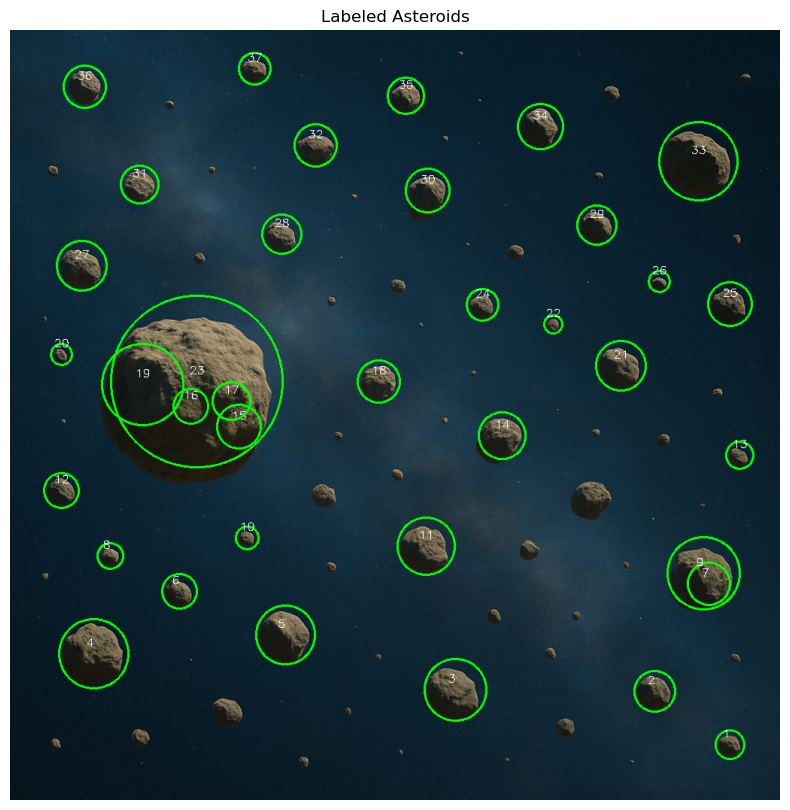

In [10]:
# If you already have 'img' as a BGR OpenCV image
# Convert BGR to RGB so matplotlib displays colors correctly
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display inline
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.title("Labeled Asteroids")
plt.axis('off')  # optional: hide axes
plt.show()

As you can see the image detection is off and we lost the smaller asteroids and the larger one is capturing multiple hits

# Tweak the min area and fine tune more

In [11]:
min_area = 275  # Tweak this depending on asteroid size
count = 0


for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > min_area:
        count += 1
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(img, center, radius, (0, 255, 0), 2)  # Green circle
        cv2.putText(img, f"{count}", (center[0]-10, center[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

# Feature Extraction / Counting

In [12]:
# === 5. Output Result ===
print(f"Detected asteroids: {count}")
cv2.imwrite("labeled_asteroids.png", img)

Detected asteroids: 53


True

In [13]:
# === 5. Output Result ===
print(f"Detected asteroids: {count}")
cv2.imwrite("labeled_asteroids.png", img)

Detected asteroids: 53


True

# Show image for visual inspection

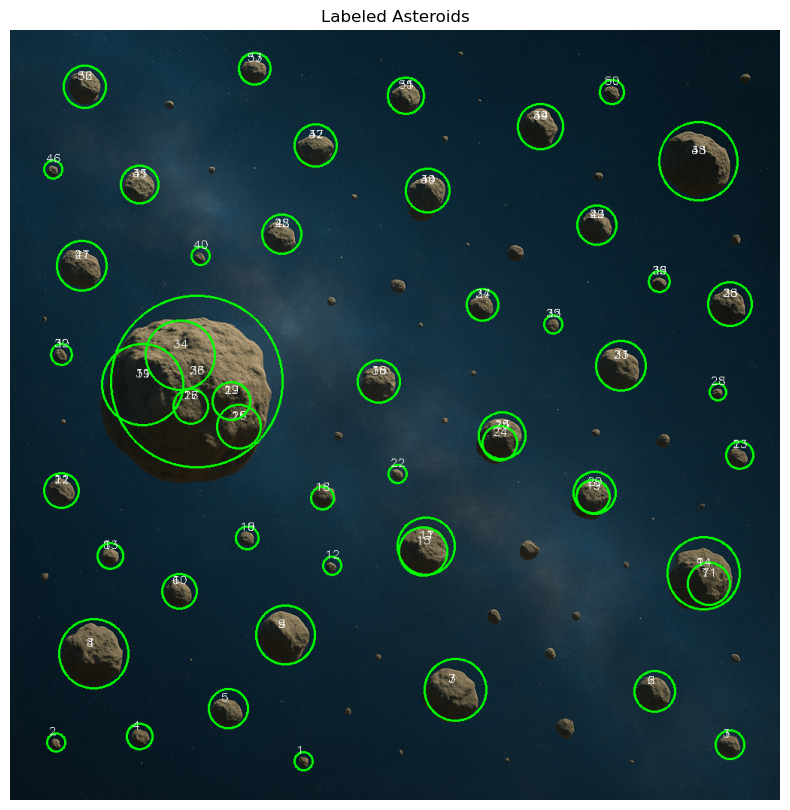

In [14]:
# If you already have 'img' as a BGR OpenCV image
# Convert BGR to RGB so matplotlib displays colors correctly
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display inline
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.title("Labeled Asteroids")
plt.axis('off')  # optional: hide axes
plt.show()

# What’s Really Happening

Big Asteroids → Labeled Multiple Times

    Their contours may be split into multiple segments due to lighting variation, shadows, or internal texture.

    Each segment has a valid area > min_area, so it gets a separate label and circle.

    This leads to multiple counts per object.

Small Asteroids → Missed

    Their contours are often:

    Faint

    Merged with background

    Smeared during blur

Or: They’re below min_area, so filtered out.


Fixes are:
1. Contour Merging (Dilation Before Threshold)
2. Remove Inner Contours (Hierarchy Filtering)


# Optimized Code to Address the Issue with Sizes of Asteroids

Total detected objects: 49


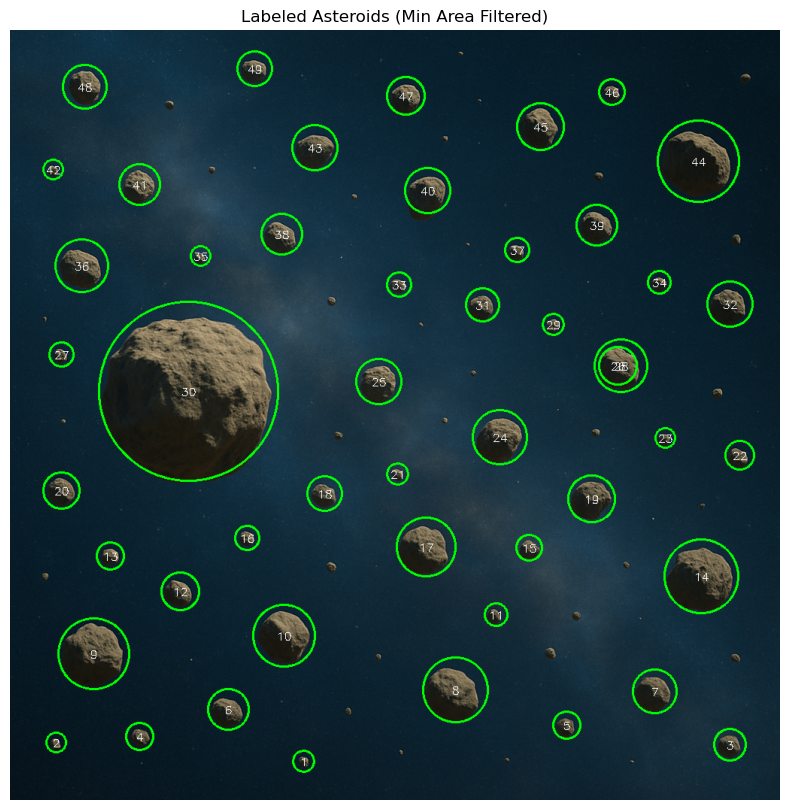

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# === Load and preprocess ===
img = cv2.imread("Asteroid_Image_Clean.png")  # <- replace with your file
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# === Thresholding ===
thresh = cv2.adaptiveThreshold(
    blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY_INV, 11, 3
)

# === Optional: Morphological merge (for split contours) ===
kernel = np.ones((3, 3), np.uint8)
dilated = cv2.dilate(thresh, kernel, iterations=1)

# === Contour Detection ===
contours, hierarchy = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# === Filtering & Drawing ===
min_area = 375
count = 0

output_img = img.copy()

for cnt in contours:
    area = cv2.contourArea(cnt)

    if area > min_area:
        count += 1
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        center = (int(x), int(y))
        radius = int(radius)

        # Draw green circle
        cv2.circle(output_img, center, radius, (0, 255, 0), 2)

        # Label with centered number
        text = str(count)
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
        text_x = center[0] - text_size[0] // 2
        text_y = center[1] + text_size[1] // 2
        cv2.putText(output_img, text, (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

print(f"Total detected objects: {count}")

# === Show result in notebook ===
img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Labeled Asteroids (Min Area Filtered)")
plt.show()

# Strategic Choice (and it’s the right one here):

We ignore the really small ones for now because they’re either:

   Too faint to reliably detect

   Likely to be misclassified as noise

   Biologically irrelevant if this were pathology (e.g., tiny fragments or artifacts)

This gives you a clean, defensible result — especially for a prototype.

# Now Lets add a Spaceship to the Asteroid Image and See What Happens...

Total detected asteroids (filtered): 39


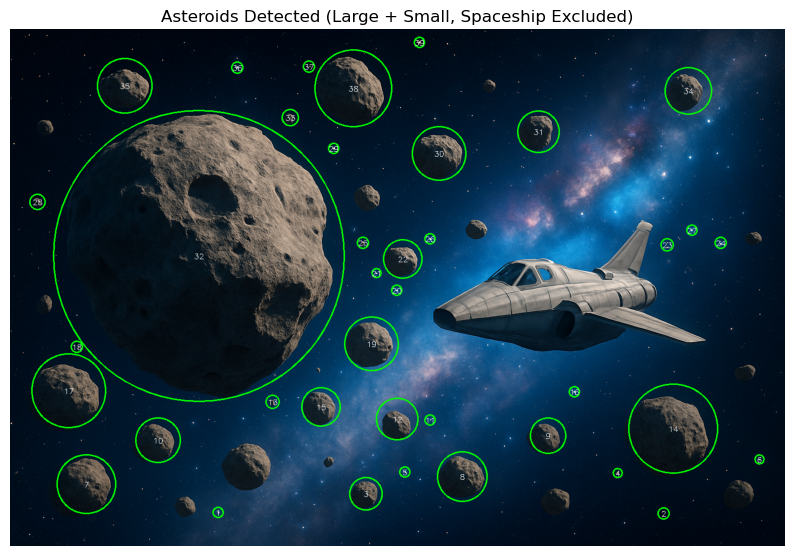

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# === 1. Load and preprocess ===
img = cv2.imread("Asteroid_Image_Spaceship.png")  # Replace with your actual filename
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# === 2. Thresholding ===
thresh = cv2.adaptiveThreshold(
    blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY_INV, 11, 3
)

# === 3. Morphological operations (optional but helpful) ===
kernel = np.ones((3, 3), np.uint8)
dilated = cv2.dilate(thresh, kernel, iterations=1)

# === 4. Contour detection ===
contours, hierarchy = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# === 5. Filter + draw ===
count = 0
output_img = img.copy()

for cnt in contours:
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    if perimeter == 0:
        continue

    circularity = 4 * np.pi * area / (perimeter ** 2)

    # Logic:
    # Small asteroids must be round-ish
    # Large asteroids are allowed to be irregular
    if (area > 200 and circularity > 0.65) or (area > 2000 and circularity > 0.15):
        count += 1
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        center = (int(x), int(y))
        radius = int(radius)

        # Draw circle
        cv2.circle(output_img, center, radius, (0, 255, 0), 2)

        # Draw label
        text = str(count)
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
        text_x = center[0] - text_size[0] // 2
        text_y = center[1] + text_size[1] // 2
        cv2.putText(output_img, text, (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

# === 6. Report count ===
print(f"Total detected asteroids (filtered): {count}")

# === 7. Show output in Jupyter ===
img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Asteroids Detected (Large + Small, Spaceship Excluded)")
plt.show()

# Futher Issue with Pipeline

Why Dark Asteroids Are Missed:

    Low contrast = weak threshold signal

        Adaptive thresholding may treat dark asteroids as background

    Lighting artifacts or shadows

        Break up one big object into noisy edges, or hide it entirely

    No true "object boundary" in pixel intensity

        Which means even perfect segmentation logic can’t "see" them